# Imports

In [1]:
config = {
    'dhdt': {
        'depth': 3,
        'learning_rate': 0.005,#1e-3,
        
        'initializer': 'GlorotUniform', #GlorotUniform
        'initializer_index': 'Ones', #GlorotUniform
        
        
        'loss': 'binary_crossentropy',#'mae',
        'optimizer': 'adam',        
        
        'beta_1': 10,
        'beta_2': 10,
        
        'activation': 'tanh', #sigmoid
        'squeeze_factor': 1,
        
        'batch_size': 512,
        'epochs': 10_000,
        'early_stopping_epochs': 50,
    },
    
    
    
    'make_classification': {
        'number_of_variables': 10,
        'n_samples': 5_000,
        'num_eval': 10,
        
        'noise': 0.1,
    },

    'computation': {
        'random_seed': 42,
        'trials': 3,
        'n_jobs': 60,
        'verbosity': 0,
    },
}



In [2]:
import numpy as np
np.set_printoptions(suppress=True)

import sklearn
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, OrdinalEncoder

from livelossplot import PlotLosses

import os
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from IPython.display import Image
from IPython.display import display, clear_output

import pandas as pd

os.environ['CUDA_VISIBLE_DEVICES'] = ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = '' #'true'

import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import logging

import tensorflow as tf
import tensorflow_addons as tfa

tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)

np.seterr(all="ignore")

from keras import backend as K
from keras.utils.generic_utils import get_custom_objects


import seaborn as sns
sns.set_style("darkgrid")

import time
import random

from utilities.utilities_updated2 import *
from utilities.DHDT_updated2 import *

from joblib import Parallel, delayed

from itertools import product
from collections.abc import Iterable

from copy import deepcopy

tf.random.set_seed(config['computation']['random_seed'])
np.random.seed(config['computation']['random_seed'])
random.seed(config['computation']['random_seed'])

# Evaluation

## make_classification

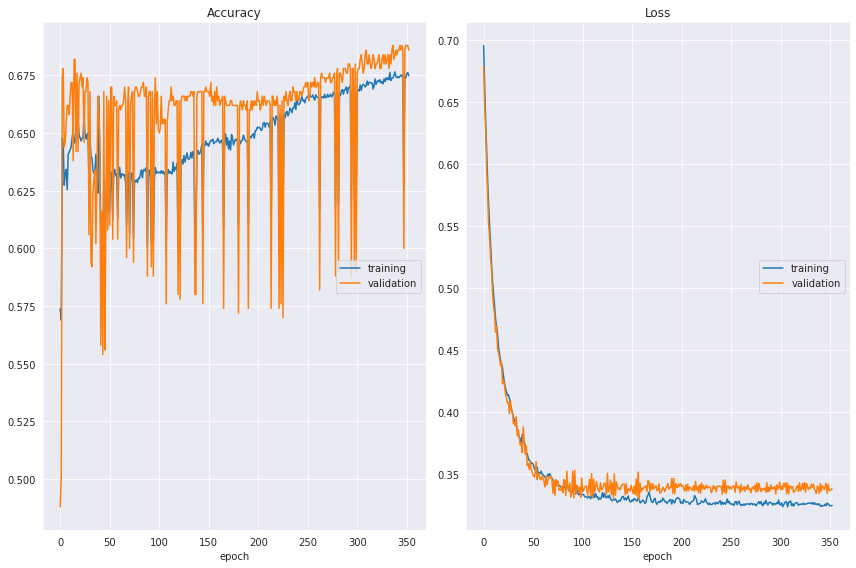

Accuracy
	training         	 (min:    0.569, max:    0.677, cur:    0.675)
	validation       	 (min:    0.488, max:    0.688, cur:    0.686)
Loss
	training         	 (min:    0.323, max:    0.696, cur:    0.324)
	validation       	 (min:    0.329, max:    0.679, cur:    0.338)
Test accuracy Sklearn (0) 0.753
Test accuracy DHDT (0) 0.699
________________________________________________________________________________________________________
Test f1 Sklearn (0) 0.7306434023991276
Test f1 DHDT (0) 0.7063414634146342
________________________________________________________________________________________________________


In [3]:
if True:
    tf.random.set_seed(config['computation']['random_seed'])
    np.random.seed(config['computation']['random_seed'])
    random.seed(config['computation']['random_seed'])  
    
    metrics = ['accuracy', 'f1']
    
    config_test = deepcopy(config)
    #config_test['make_classification']['n_samples'] = 10_000
    #config_test['dhdt']['epochs'] = 50
    #config_test['dhdt']['initializer_index'] = 'he_normal'#'ones', #GlorotUniform
    #config_test['dhdt']['activation'] = 'sigmoid'

    dataset_dict = {}
    model_dict = {}

    scores_dict = {'sklearn': {},
                   'DHDT': {}}
    
    dataset_dict = get_preprocessed_dataset('make_classification',
                                            random_seed=config_test['computation']['random_seed'],
                                            config=config_test['make_classification'],
                                            verbosity=2)

    model_dict['sklearn'] = DecisionTreeClassifier(max_depth=3, 
                                                   random_state=config_test['computation']['random_seed'])

    model_dict['sklearn'].fit(dataset_dict['X_train'], 
                              dataset_dict['y_train'])



    model_dict['DHDT'] = DHDT(dataset_dict['X_train'].shape[1],

                                depth = config_test['dhdt']['depth'],

                                learning_rate = config_test['dhdt']['learning_rate'],
                                optimizer = config_test['dhdt']['optimizer'],
                              
                                initializer = config_test['dhdt']['initializer'],
                                initializer_index = config_test['dhdt']['initializer_index'],
                              
                                beta_1 = config_test['dhdt']['beta_1'],
                                beta_2 = config_test['dhdt']['beta_2'],

                                activation = config_test['dhdt']['activation'],
                                squeeze_factor = config_test['dhdt']['squeeze_factor'],

                                loss = config_test['dhdt']['loss'],#'mae',

                                random_seed = config_test['computation']['random_seed'],
                                verbosity = 1)#5        


    scores_dict['history'] = model_dict['DHDT'].fit(dataset_dict['X_train'], 
                                                  dataset_dict['y_train'], 
                                                  batch_size=config_test['dhdt']['batch_size'], 
                                                  epochs=config_test['dhdt']['epochs'], 
                                                  early_stopping_epochs=config_test['dhdt']['early_stopping_epochs'], 
                                                  valid_data=(dataset_dict['X_valid'], dataset_dict['y_valid']))


    dataset_dict['y_test_dhdt'] = model_dict['DHDT'].predict(dataset_dict['X_test'])
    dataset_dict['y_valid_dhdt'] = model_dict['DHDT'].predict(dataset_dict['X_valid'])

    dataset_dict['y_test_sklearn'] = model_dict['sklearn'].predict(dataset_dict['X_test'])
    dataset_dict['y_valid_sklearn'] = model_dict['sklearn'].predict(dataset_dict['X_valid'])     
    
    for metric in metrics:
        
        if metric in ['accuracy', 'f1']:
            y_test_dhdt = np.round(dataset_dict['y_test_dhdt'])
            y_valid_dhdt = np.round(dataset_dict['y_valid_dhdt'])
            y_test_sklearn = np.round(dataset_dict['y_test_sklearn'])
            y_valid_sklearn = np.round(dataset_dict['y_valid_sklearn'])         
        else:
            y_test_dhdt = dataset_dict['y_test_dhdt']
            y_valid_dhdt = dataset_dict['y_valid_dhdt']
            y_test_sklearn = dataset_dict['y_test_sklearn']
            y_valid_sklearn =    dataset_dict['y_valid_sklearn']                
        
        scores_dict['sklearn'][metric + '_test'] = sklearn.metrics.get_scorer(metric)._score_func(dataset_dict['y_test'], y_test_sklearn)
        scores_dict['DHDT'][metric + '_test'] = sklearn.metrics.get_scorer(metric)._score_func(dataset_dict['y_test'], y_test_dhdt)

        scores_dict['sklearn'][metric + '_valid'] = sklearn.metrics.get_scorer(metric)._score_func(dataset_dict['y_valid'], y_valid_sklearn)   
        scores_dict['DHDT'][metric + '_valid'] = sklearn.metrics.get_scorer(metric)._score_func(dataset_dict['y_valid'], y_valid_dhdt)

        print('Test ' + metric + ' Sklearn (' + str(0) + ')', scores_dict['sklearn'][metric + '_test'])
        print('Test ' + metric + ' DHDT (' + str(0) + ')', scores_dict['DHDT'][metric + '_test'])   
        print('________________________________________________________________________________________________________')   


In [4]:
if False:    
    plt.figure(figsize=(15,8))
    image = model_dict['DHDT'].plot()
    display(image)

    plt.figure(figsize=(15,8))
    plot_tree(model_dict['sklearn'], fontsize=10) 
    plt.show()

In [5]:
if False:    
    plt.figure(figsize=(15,8))
    image = model_dict['DHDT'].plot(normalizer_list=dataset_dict['normalizer_list'])
    display(image)

    plt.figure(figsize=(15,8))
    plot_tree(model_dict['sklearn'], fontsize=10) 
    plt.show()

In [6]:
if False:
    parallel_eval_synthetic = Parallel(n_jobs=config['computation']['n_jobs'], verbose=3, backend='loky') #loky #sequential multiprocessing
    evaluation_results_synthetic = parallel_eval_synthetic(delayed(evaluate_synthetic_parallel)(index = index,
                                                                                                random_seed_data = config['computation']['random_seed']+index,
                                                                                                random_seed_model = config['computation']['random_seed'],#+random_seed_model,
                                                                                                config = config,
                                                                                                verbosity = -1) for index in range(config['make_classification']['num_eval']))

    for i, synthetic_result in enumerate(evaluation_results_synthetic):
        if i == 0:
            model_dict_synthetic = synthetic_result[0]
            scores_dict_synthetic = synthetic_result[1]
            dataset_dict_synthetic = synthetic_result[2]
        else: 
            model_dict_synthetic = mergeDict(model_dict_synthetic, synthetic_result[0])
            scores_dict_synthetic = mergeDict(scores_dict_synthetic, synthetic_result[1])
            dataset_dict_synthetic = mergeDict(dataset_dict_synthetic, synthetic_result[2])        
    
    metric_identifer = '_test'
    metrics = ['accuracy', 'f1']
    index = [i for i in range(config['make_classification']['num_eval'])]
    columns = flatten_list([[[approach + ' ' + metric + '_mean', approach + ' ' + metric + '_max', approach + ' ' + metric + '_std'] for metric in metrics] for approach in ['DHDT', 'sklearn']])


    results_DHDT = None
    results_sklearn = None
    for metric in metrics:
        scores_DHDT = [scores_dict_synthetic[i]['DHDT'][metric + metric_identifer] for i in range(config['make_classification']['num_eval'])]

        scores_sklearn = [scores_dict_synthetic[i]['sklearn'][metric + metric_identifer] for i in range(config['make_classification']['num_eval'])]

        scores_DHDT_mean = np.mean(scores_DHDT, axis=1) if config['computation']['trials'] > 1 else scores_DHDT
        scores_sklearn_mean = np.mean(scores_sklearn, axis=1) if config['computation']['trials'] > 1 else scores_sklearn

        scores_DHDT_max = np.max(scores_DHDT, axis=1) if config['computation']['trials'] > 1 else scores_DHDT
        scores_sklearn_max = np.max(scores_sklearn, axis=1) if config['computation']['trials'] > 1 else scores_sklearn

        scores_DHDT_std = np.std(scores_DHDT, axis=1) if config['computation']['trials'] > 1 else np.array([0.0] * config['computation']['trials'])
        scores_sklearn_std = np.std(scores_sklearn, axis=1) if config['computation']['trials'] > 1 else np.array([0.0] * config['computation']['trials'])

        results_DHDT_by_metric = np.vstack([scores_DHDT_mean, scores_DHDT_max, scores_DHDT_std])
        results_sklearn_by_metric = np.vstack([scores_sklearn_mean, scores_sklearn_max, scores_sklearn_std])

        if results_DHDT is None and results_sklearn is None:
            results_DHDT = results_DHDT_by_metric
            results_sklearn = results_sklearn_by_metric
        else:
            results_DHDT = np.vstack([results_DHDT, results_DHDT_by_metric])
            results_sklearn = np.vstack([results_sklearn, results_sklearn_by_metric])

    scores_dataframe_synthetic = pd.DataFrame(data=np.vstack([results_DHDT, results_sklearn]).T, index = index, columns = columns)    
        
    index = [index_name.split(' ')[1] for index_name in scores_dataframe_synthetic.mean()[scores_dataframe_synthetic.shape[1]//2:].index]
    mean_result_dataframe_synthetic = np.round(pd.DataFrame(data=np.vstack([scores_dataframe_synthetic.mean()[:scores_dataframe_synthetic.shape[1]//2], scores_dataframe_synthetic.mean()[scores_dataframe_synthetic.shape[1]//2:]]).T, index=index, columns=['DHDT', 'sklearn']), 3)

        
    display(scores_dataframe_synthetic.head(5))
    display(scores_dataframe_synthetic[scores_dataframe_synthetic.columns[0::3]].iloc[:,[0,2,1,3]].head(5))
    display(scores_dataframe_synthetic[scores_dataframe_synthetic.columns[1::3]].iloc[:,[0,2,1,3]].head(5))
    display(mean_result_dataframe_synthetic)
    

In [7]:
if False:
    plot_index = 0
    
    plt.figure(figsize=(15,8))
    image = model_dict_synthetic[1]['DHDT'][plot_index].plot(normalizer_list=dataset_dict_synthetic[1]['normalizer_list'])
    display(image)

    plt.figure(figsize=(15,8))
    plot_tree(model_dict_synthetic[1]['sklearn'][plot_index], fontsize=10) 
    plt.show()

## Real-World Eval

In [8]:
if False:

    identifier_list = [
                        'Adult',#: 32,
                        'Bank Marketing',#: 32,
                        'Loan Credit',#: 32,

                        'Credit Card',#: 23, 
                        'Car',#: 21,


                        'Absenteeism',#: 15,
                        'Loan House',#: 15,
                        'Cervical Cancer',#: 15,

                        'Heart Disease',#: 13,           

                        'Titanic',#: 10,
                        'Medical Insurance',#: 10,
                        'Wisconsin Breast Cancer Original',#: 10,
                        'Wisconsin Diagnostic Breast Cancer',#: 10,
                        'Wisconsin Prognostic Breast Cancer',#: 10,
                        'Abalone',#: 10,

                        'Habermans Survival',#: 3, 
                      ]
    
    parallel_eval_real_world = Parallel(n_jobs=config['computation']['n_jobs'], verbose=3, backend='loky') #loky #sequential multiprocessing
    evaluation_results_real_world = parallel_eval_real_world(delayed(evaluate_real_world_parallel)(identifier_list=identifier_list, 
                                                                                                   random_seed_model=config['computation']['random_seed']+i,
                                                                                                   config = config,
                                                                                                   verbosity = -1) for i in range(config['computation']['trials']))


    for i, real_world_result in enumerate(evaluation_results_real_world):
        if i == 0:
            model_dict_real_world = real_world_result[0]
            scores_dict_real_world = real_world_result[1]
            dataset_dict_real_world = real_world_result[2]
        else: 
            model_dict_real_world = mergeDict(model_dict_real_world, real_world_result[0])
            scores_dict_real_world = mergeDict(scores_dict_real_world, real_world_result[1])
            dataset_dict_real_world = mergeDict(dataset_dict_real_world, real_world_result[2])    

    metric_identifer = '_test'
    metrics = ['accuracy', 'f1']
    index = identifier_list
    columns = flatten_list([[[approach + ' ' + metric + '_mean', approach + ' ' + metric + '_max', approach + ' ' + metric + '_std'] for metric in metrics] for approach in ['DHDT', 'sklearn']])


    results_DHDT = None
    results_sklearn = None
    for metric in metrics:
        scores_DHDT = [scores_dict_real_world[identifier]['DHDT'][metric + metric_identifer] for identifier in identifier_list]

        scores_sklearn = [scores_dict_real_world[identifier]['sklearn'][metric + metric_identifer] for identifier in identifier_list]    

        scores_DHDT_mean = np.mean(scores_DHDT, axis=1) if config['computation']['trials'] > 1 else scores_DHDT
        scores_sklearn_mean = np.mean(scores_sklearn, axis=1) if config['computation']['trials'] > 1 else scores_sklearn

        scores_DHDT_max = np.max(scores_DHDT, axis=1) if config['computation']['trials'] > 1 else scores_DHDT
        scores_sklearn_max = np.max(scores_sklearn, axis=1) if config['computation']['trials'] > 1 else scores_sklearn

        scores_DHDT_std = np.std(scores_DHDT, axis=1) if config['computation']['trials'] > 1 else np.array([0.0] * config['computation']['trials'])
        scores_sklearn_std = np.std(scores_sklearn, axis=1) if config['computation']['trials'] > 1 else np.array([0.0] * config['computation']['trials'])

        results_DHDT_by_metric = np.vstack([scores_DHDT_mean, scores_DHDT_max, scores_DHDT_std])
        results_sklearn_by_metric = np.vstack([scores_sklearn_mean, scores_sklearn_max, scores_sklearn_std])

        if results_DHDT is None and results_sklearn is None:
            results_DHDT = results_DHDT_by_metric
            results_sklearn = results_sklearn_by_metric
        else:
            results_DHDT = np.vstack([results_DHDT, results_DHDT_by_metric])
            results_sklearn = np.vstack([results_sklearn, results_sklearn_by_metric])
            
    scores_dataframe_real_world = pd.DataFrame(data=np.vstack([results_DHDT, results_sklearn]).T, index = index, columns = columns)
            
    index = [index_name.split(' ')[1] for index_name in scores_dataframe_real_world.mean()[scores_dataframe_real_world.shape[1]//2:].index]
    mean_result_dataframe_real_world = np.round(pd.DataFrame(data=np.vstack([scores_dataframe_real_world.mean()[:scores_dataframe_real_world.shape[1]//2], scores_dataframe_real_world.mean()[scores_dataframe_real_world.shape[1]//2:]]).T, index=index, columns=['DHDT', 'sklearn']), 3)
                
    display(scores_dataframe_real_world)
    display(scores_dataframe_real_world[scores_dataframe_real_world.columns[0::3]].iloc[:,[0,2,1,3]])    
    display(scores_dataframe_real_world[scores_dataframe_real_world.columns[1::3]].iloc[:,[0,2,1,3]])    

    display(mean_result_dataframe_real_world)
    


In [9]:
if False:
    plot_index = 0
    
    identifier = identifier_list[0]#"Absenteeism"
    plt.figure(figsize=(15,8))
    image = model_dict_real_world[identifier]['DHDT'][plot_index].plot(normalizer_list=dataset_dict_real_world[identifier]['normalizer_list'])
    display(image)

    plt.figure(figsize=(15,8))
    plot_tree(model_dict_real_world[identifier]['sklearn'][plot_index], fontsize=10) 
    plt.show()

# Hyperparameter Optimization

In [10]:
parameter_dict = {
        'depth': [3],
        'learning_rate': [0.01], #[0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001],
        
        'loss': ['binary_crossentropy'], #['binary_crossentropy', 'rmse'], #'mae',
        'optimizer': ['adam'], #['adam', 'sgd', 'rmsprop'],        
        
        'initializer': ['RandomUniform', 'GlorotNormal', 'Zeros'],#['GlorotUniform', 'GlorotNormal', 'HeUniform', 'HeNormal', 'LecunUniform', 'LecunNormal', 'RandomNormal', 'RandomUniform'], #RandomNormal, RandomUniform
        'initializer_index': ['Zeros'],#['GlorotUniform', 'GlorotNormal', 'HeUniform', 'HeNormal', 'LecunUniform', 'LecunNormal', 'RandomNormal', 'RandomUniform', 'Zeros', 'Ones'], #RandomNormal, RandomUniform

        'beta_1': [1, 5, 10, 20], #[10, 50, 100],
        'beta_2': [1, 5, 10, 20], #[10, 50, 100],
        
        'activation': ['tanh'], #'sigmoid'
        'squeeze_factor': [1],#[0.2, 0.5, 1, 2, 5], #[0.2, 0.5, 1, 2, 5],    
}

parameter_grid = ParameterGrid(parameter_dict)

In [11]:
if True:
    parallel_hpo_synthetic = Parallel(n_jobs=config['computation']['n_jobs'], verbose=3, backend='loky') #loky #sequential multiprocessing
    evaluation_results_hpo_synthetic = parallel_hpo_synthetic(delayed(evaluate_parameter_setting_synthetic)(parameter_setting, config, metrics= ['accuracy', 'f1']) for parameter_setting in parameter_grid)

    comparator_metric = 'f1'

    dhdt_mean_list_unsorted = [np.mean(evaluation_results_hpo_synthetic[i][0]['DHDT ' + comparator_metric + '_mean']) for i in range(len(parameter_grid))]
    dhdt_mean_list = sorted(dhdt_mean_list_unsorted, reverse=True)

    dhdt_max_mean_list_unsorted = [np.mean(evaluation_results_hpo_synthetic[i][0]['DHDT ' + comparator_metric + '_max']) for i in range(len(parameter_grid))]
    dhdt_max_mean_list = [x for (y,x) in sorted(zip(dhdt_mean_list_unsorted, dhdt_max_mean_list_unsorted), key=lambda pair: pair[0], reverse=True)]
    #[x for _, x in sorted(zip(dhdt_mean_list, dhdt_max_mean_list), reverse=True)]

    sklearn_mean_list_unsorted = [np.mean(evaluation_results_hpo_synthetic[i][0]['sklearn ' + comparator_metric + '_mean']) for i in range(len(parameter_grid))]
    sklearn_mean_list = [x for (y,x) in sorted(zip(dhdt_mean_list_unsorted, sklearn_mean_list_unsorted), key=lambda pair: pair[0], reverse=True)]
    #[x for _, x in sorted(zip(dhdt_mean_list, sklearn_mean_list), reverse=True)]

    parameter_setting_list_unsorted = [evaluation_results_hpo_synthetic[i][1] for i in range(len(parameter_grid))]
    parameter_setting_list = [x for (y,x) in sorted(zip(dhdt_mean_list_unsorted, parameter_setting_list_unsorted), key=lambda pair: pair[0], reverse=True)]
    #[x for _, x in sorted(zip(dhdt_mean_list, parameter_setting_list), reverse=True)]

    hpo_results_synthetic = []
    for i, (dhdt_mean, dhdt_max_mean, sklearn_mean, parameter_setting) in enumerate(zip(dhdt_mean_list, dhdt_max_mean_list, sklearn_mean_list, parameter_setting_list)):
        result_dict = {
                             'DHDT mean (mean)': dhdt_mean,
                             'DHDT max (mean)': dhdt_max_mean,
                             'sklearn mean': sklearn_mean,
                             'parameters': parameter_setting
                            }

        hpo_results_synthetic.append(result_dict)

    display(hpo_results_synthetic[:5])

[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done  14 out of  48 | elapsed: 13.6min remaining: 33.1min
[Parallel(n_jobs=60)]: Done  31 out of  48 | elapsed: 15.8min remaining:  8.7min
[Parallel(n_jobs=60)]: Done  48 out of  48 | elapsed: 33.0min remaining:    0.0s
[Parallel(n_jobs=60)]: Done  48 out of  48 | elapsed: 33.0min finished


[{'DHDT mean (mean)': 0.7069454151465387,
  'DHDT max (mean)': 0.7485352020656022,
  'sklearn mean': 0.7659584388206563,
  'parameters': {'activation': 'tanh',
   'beta_1': 20,
   'beta_2': 20,
   'depth': 3,
   'initializer': 'Zeros',
   'initializer_index': 'Zeros',
   'learning_rate': 0.01,
   'loss': 'binary_crossentropy',
   'optimizer': 'adam',
   'squeeze_factor': 1}},
 {'DHDT mean (mean)': 0.7006786021591254,
  'DHDT max (mean)': 0.764565900782399,
  'sklearn mean': 0.7636915949445593,
  'parameters': {'activation': 'tanh',
   'beta_1': 20,
   'beta_2': 5,
   'depth': 3,
   'initializer': 'Zeros',
   'initializer_index': 'Zeros',
   'learning_rate': 0.01,
   'loss': 'binary_crossentropy',
   'optimizer': 'adam',
   'squeeze_factor': 1}},
 {'DHDT mean (mean)': 0.6996659656552766,
  'DHDT max (mean)': 0.7384258908155737,
  'sklearn mean': 0.7617308252603863,
  'parameters': {'activation': 'tanh',
   'beta_1': 20,
   'beta_2': 20,
   'depth': 3,
   'initializer': 'RandomUniform',


In [12]:
if True:
    identifier_list = [
                        #'Adult',#: 32,
                        #'Bank Marketing',#: 32,
                        #'Loan Credit',#: 32,

                        #'Credit Card',#: 23, 
                        'Car',#: 21,


                        'Absenteeism',#: 15,
                        ##'Loan House',#: 15, 
                        'Cervical Cancer',#: 15,

                        ##'Heart Disease',#: 13,           

                        'Titanic',#: 10,
                        'Medical Insurance',#: 10,
                        'Wisconsin Breast Cancer Original',#: 10,
                        #'Wisconsin Diagnostic Breast Cancer',#: 10,
                        'Wisconsin Prognostic Breast Cancer',#: 10,
                        'Abalone',#: 10,

                        'Habermans Survival',#: 3, 
                      ]

    hpo_results_real_world = {}
    hpo_results_real_world_unsorted = {}
    print('___________________________________________________________________________')
    
    for identifier in identifier_list:
        print(identifier)
        
        parallel_hpo_real = Parallel(n_jobs=config['computation']['n_jobs'], verbose=3, backend='loky') #loky #sequential multiprocessing
        evaluation_results_hpo_real = parallel_hpo_real(delayed(evaluate_parameter_setting_real_world)(parameter_setting, 
                                                                                                       identifier, 
                                                                                                       config, 
                                                                                                       metrics = ['accuracy', 'f1']) for parameter_setting in parameter_grid)

        comparator_metric = 'f1'

        dhdt_mean_list_unsorted = [np.mean(evaluation_results_hpo_real[i][0]['DHDT ' + comparator_metric + '_mean']) for i in range(len(parameter_grid))]
        dhdt_mean_list = sorted(dhdt_mean_list_unsorted, reverse=True)

        dhdt_max_mean_list_unsorted = [np.mean(evaluation_results_hpo_real[i][0]['DHDT ' + comparator_metric + '_max']) for i in range(len(parameter_grid))]
        dhdt_max_mean_list = [x for (y,x) in sorted(zip(dhdt_mean_list_unsorted, dhdt_max_mean_list_unsorted), key=lambda pair: pair[0], reverse=True)]
        #[x for _, x in sorted(zip(dhdt_mean_list_unsorted, dhdt_max_mean_list), reverse=True)]

        sklearn_mean_list_unsorted = [np.mean(evaluation_results_hpo_real[i][0]['sklearn ' + comparator_metric + '_mean']) for i in range(len(parameter_grid))]
        sklearn_mean_list = [x for (y,x) in sorted(zip(dhdt_mean_list_unsorted, sklearn_mean_list_unsorted), key=lambda pair: pair[0], reverse=True)]
        #[x for _, x in sorted(zip(dhdt_mean_list_unsorted, sklearn_mean_list), reverse=True)]

        parameter_setting_list_unsorted = [evaluation_results_hpo_real[i][1] for i in range(len(parameter_grid))]
        parameter_setting_list = [x for (y,x) in sorted(zip(dhdt_mean_list_unsorted, parameter_setting_list_unsorted), key=lambda pair: pair[0], reverse=True)]
        #[x for _, x in sorted(zip(dhdt_mean_list_unsorted, parameter_setting_list), reverse=True)]

        hpo_results_real_world_by_identifer = []
        for i, (dhdt_mean, dhdt_max_mean, sklearn_mean, parameter_setting) in enumerate(zip(dhdt_mean_list, dhdt_max_mean_list, sklearn_mean_list, parameter_setting_list)):
            result_dict = {
                                 'DHDT mean (mean)': dhdt_mean,
                                 'DHDT max (mean)': dhdt_max_mean,
                                 'sklearn mean': sklearn_mean,
                                 'parameters': parameter_setting
                                }

            hpo_results_real_world_by_identifer.append(result_dict)

        hpo_results_real_world[identifier] = hpo_results_real_world_by_identifer
        
        hpo_results_real_world_by_identifer_unsorted = []
        for i, (dhdt_mean, dhdt_max_mean, sklearn_mean, parameter_setting) in enumerate(zip(dhdt_mean_list_unsorted, dhdt_max_mean_list_unsorted, sklearn_mean_list_unsorted, parameter_setting_list_unsorted)):
            result_dict_unsorted = {
                                 'DHDT mean (mean)': dhdt_mean,
                                 'DHDT max (mean)': dhdt_max_mean,
                                 'sklearn mean': sklearn_mean,
                                 'parameters': parameter_setting
                                }

            hpo_results_real_world_by_identifer_unsorted.append(result_dict_unsorted)

        hpo_results_real_world_unsorted[identifier] = hpo_results_real_world_by_identifer_unsorted      

        print('')
        #display(hpo_results_real_world_by_identifer[:1])
        print('___________________________________________________________________________')
        
    best_scores_DHDT = [hpo_results_real_world[key][0]['DHDT mean (mean)'] for key in hpo_results_real_world.keys()]
    scores_sklearn = [hpo_results_real_world[key][0]['sklearn mean'] for key in hpo_results_real_world.keys()]

    real_world_best_results = pd.DataFrame(data=np.vstack([best_scores_DHDT, scores_sklearn]).T, index=list(hpo_results_real_world.keys()), columns=['DHDT (mean)', 'sklearn (mean)'])
    real_world_best_results_mean = real_world_best_results.mean()
    real_world_best_results_mean.name = 'MEAN'

    real_world_best_results = real_world_best_results.append(real_world_best_results_mean)    
    display(real_world_best_results)
        

___________________________________________________________________________
Car


[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done  14 out of  48 | elapsed:   50.9s remaining:  2.1min
[Parallel(n_jobs=60)]: Done  31 out of  48 | elapsed:   54.9s remaining:   30.1s
[Parallel(n_jobs=60)]: Done  48 out of  48 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=60)]: Done  48 out of  48 | elapsed:  2.7min finished
[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.



___________________________________________________________________________
Absenteeism


[Parallel(n_jobs=60)]: Done  14 out of  48 | elapsed:   26.3s remaining:  1.1min
[Parallel(n_jobs=60)]: Done  31 out of  48 | elapsed:   29.7s remaining:   16.3s
[Parallel(n_jobs=60)]: Done  48 out of  48 | elapsed:   38.9s remaining:    0.0s
[Parallel(n_jobs=60)]: Done  48 out of  48 | elapsed:   38.9s finished
[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.



___________________________________________________________________________
Cervical Cancer


[Parallel(n_jobs=60)]: Done  14 out of  48 | elapsed:   36.3s remaining:  1.5min
[Parallel(n_jobs=60)]: Done  31 out of  48 | elapsed:   43.4s remaining:   23.8s
[Parallel(n_jobs=60)]: Done  48 out of  48 | elapsed:   56.0s remaining:    0.0s
[Parallel(n_jobs=60)]: Done  48 out of  48 | elapsed:   56.0s finished
[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.



___________________________________________________________________________
Titanic


[Parallel(n_jobs=60)]: Done  14 out of  48 | elapsed:   26.2s remaining:  1.1min
[Parallel(n_jobs=60)]: Done  31 out of  48 | elapsed:   29.1s remaining:   16.0s
[Parallel(n_jobs=60)]: Done  48 out of  48 | elapsed:   35.9s remaining:    0.0s
[Parallel(n_jobs=60)]: Done  48 out of  48 | elapsed:   35.9s finished
[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.



___________________________________________________________________________
Medical Insurance


[Parallel(n_jobs=60)]: Done  14 out of  48 | elapsed:   46.9s remaining:  1.9min
[Parallel(n_jobs=60)]: Done  31 out of  48 | elapsed:   50.0s remaining:   27.4s
[Parallel(n_jobs=60)]: Done  48 out of  48 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=60)]: Done  48 out of  48 | elapsed:  1.1min finished
[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.



___________________________________________________________________________
Wisconsin Breast Cancer Original


[Parallel(n_jobs=60)]: Done  14 out of  48 | elapsed:  2.2min remaining:  5.4min
[Parallel(n_jobs=60)]: Done  31 out of  48 | elapsed:  3.5min remaining:  1.9min



___________________________________________________________________________
Wisconsin Prognostic Breast Cancer


[Parallel(n_jobs=60)]: Done  48 out of  48 | elapsed:  5.4min remaining:    0.0s
[Parallel(n_jobs=60)]: Done  48 out of  48 | elapsed:  5.4min finished
[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done  14 out of  48 | elapsed:   57.4s remaining:  2.3min
[Parallel(n_jobs=60)]: Done  31 out of  48 | elapsed:  1.8min remaining:   59.8s



___________________________________________________________________________
Abalone


[Parallel(n_jobs=60)]: Done  48 out of  48 | elapsed:  4.6min remaining:    0.0s
[Parallel(n_jobs=60)]: Done  48 out of  48 | elapsed:  4.6min finished
[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done  14 out of  48 | elapsed:  1.2min remaining:  2.9min
[Parallel(n_jobs=60)]: Done  31 out of  48 | elapsed:  1.5min remaining:   47.8s



___________________________________________________________________________
Habermans Survival


[Parallel(n_jobs=60)]: Done  48 out of  48 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=60)]: Done  48 out of  48 | elapsed:  2.3min finished
[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done  14 out of  48 | elapsed:   55.1s remaining:  2.2min
[Parallel(n_jobs=60)]: Done  31 out of  48 | elapsed:  1.6min remaining:   54.1s



___________________________________________________________________________


[Parallel(n_jobs=60)]: Done  48 out of  48 | elapsed:  4.3min remaining:    0.0s
[Parallel(n_jobs=60)]: Done  48 out of  48 | elapsed:  4.3min finished


,DHDT (mean),sklearn (mean)
Car,0.670022,0.714286
Absenteeism,0.588366,0.461538
Cervical Cancer,0.298901,0.166667
Titanic,0.653864,0.686567
Medical Insurance,0.914832,0.896552
Wisconsin Breast Cancer Original,0.958647,0.867925
Wisconsin Prognostic Breast Cancer,0.750000,0.800000
Abalone,0.631818,0.591241
Habermans Survival,0.870370,0.909091
MEAN,0.704091,0.677096


In [14]:
for key, value in hpo_results_real_world.items():
    print('___________________________________________________________________________')
    print(key)
    display(value[:1])

___________________________________________________________________________
Car


[{'DHDT mean (mean)': 0.6700218730560071,
  'DHDT max (mean)': 0.7964601769911505,
  'sklearn mean': 0.7142857142857141,
  'parameters': {'activation': 'tanh',
   'beta_1': 10,
   'beta_2': 1,
   'depth': 3,
   'initializer': 'RandomUniform',
   'initializer_index': 'Zeros',
   'learning_rate': 0.01,
   'loss': 'binary_crossentropy',
   'optimizer': 'adam',
   'squeeze_factor': 1}}]

___________________________________________________________________________
Absenteeism


[{'DHDT mean (mean)': 0.5883658122747307,
  'DHDT max (mean)': 0.6129032258064516,
  'sklearn mean': 0.4615384615384615,
  'parameters': {'activation': 'tanh',
   'beta_1': 1,
   'beta_2': 5,
   'depth': 3,
   'initializer': 'Zeros',
   'initializer_index': 'Zeros',
   'learning_rate': 0.01,
   'loss': 'binary_crossentropy',
   'optimizer': 'adam',
   'squeeze_factor': 1}}]

___________________________________________________________________________
Cervical Cancer


[{'DHDT mean (mean)': 0.2989010989010989,
  'DHDT max (mean)': 0.4761904761904762,
  'sklearn mean': 0.16666666666666666,
  'parameters': {'activation': 'tanh',
   'beta_1': 20,
   'beta_2': 1,
   'depth': 3,
   'initializer': 'GlorotNormal',
   'initializer_index': 'Zeros',
   'learning_rate': 0.01,
   'loss': 'binary_crossentropy',
   'optimizer': 'adam',
   'squeeze_factor': 1}}]

___________________________________________________________________________
Titanic


[{'DHDT mean (mean)': 0.6538638484693141,
  'DHDT max (mean)': 0.7341772151898734,
  'sklearn mean': 0.6865671641791046,
  'parameters': {'activation': 'tanh',
   'beta_1': 1,
   'beta_2': 5,
   'depth': 3,
   'initializer': 'GlorotNormal',
   'initializer_index': 'Zeros',
   'learning_rate': 0.01,
   'loss': 'binary_crossentropy',
   'optimizer': 'adam',
   'squeeze_factor': 1}}]

___________________________________________________________________________
Medical Insurance


[{'DHDT mean (mean)': 0.914831882573818,
  'DHDT max (mean)': 0.9206349206349206,
  'sklearn mean': 0.896551724137931,
  'parameters': {'activation': 'tanh',
   'beta_1': 20,
   'beta_2': 5,
   'depth': 3,
   'initializer': 'Zeros',
   'initializer_index': 'Zeros',
   'learning_rate': 0.01,
   'loss': 'binary_crossentropy',
   'optimizer': 'adam',
   'squeeze_factor': 1}}]

___________________________________________________________________________
Wisconsin Breast Cancer Original


[{'DHDT mean (mean)': 0.9586466165413534,
  'DHDT max (mean)': 0.9642857142857143,
  'sklearn mean': 0.8679245283018867,
  'parameters': {'activation': 'tanh',
   'beta_1': 1,
   'beta_2': 20,
   'depth': 3,
   'initializer': 'RandomUniform',
   'initializer_index': 'Zeros',
   'learning_rate': 0.01,
   'loss': 'binary_crossentropy',
   'optimizer': 'adam',
   'squeeze_factor': 1}}]

___________________________________________________________________________
Wisconsin Prognostic Breast Cancer


[{'DHDT mean (mean)': 0.75,
  'DHDT max (mean)': 0.75,
  'sklearn mean': 0.7999999999999999,
  'parameters': {'activation': 'tanh',
   'beta_1': 5,
   'beta_2': 20,
   'depth': 3,
   'initializer': 'Zeros',
   'initializer_index': 'Zeros',
   'learning_rate': 0.01,
   'loss': 'binary_crossentropy',
   'optimizer': 'adam',
   'squeeze_factor': 1}}]

___________________________________________________________________________
Abalone


[{'DHDT mean (mean)': 0.6318180032465747,
  'DHDT max (mean)': 0.6366366366366366,
  'sklearn mean': 0.5912408759124087,
  'parameters': {'activation': 'tanh',
   'beta_1': 20,
   'beta_2': 1,
   'depth': 3,
   'initializer': 'GlorotNormal',
   'initializer_index': 'Zeros',
   'learning_rate': 0.01,
   'loss': 'binary_crossentropy',
   'optimizer': 'adam',
   'squeeze_factor': 1}}]

___________________________________________________________________________
Habermans Survival


[{'DHDT mean (mean)': 0.8703703703703703,
  'DHDT max (mean)': 0.888888888888889,
  'sklearn mean': 0.9090909090909088,
  'parameters': {'activation': 'tanh',
   'beta_1': 20,
   'beta_2': 20,
   'depth': 3,
   'initializer': 'GlorotNormal',
   'initializer_index': 'Zeros',
   'learning_rate': 0.01,
   'loss': 'binary_crossentropy',
   'optimizer': 'adam',
   'squeeze_factor': 1}}]